In [1]:
#!pip install kaleido

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px 
import kaleido
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


## **Step 1: Gather data, determine the method of data collection and provenance of the data**

The data source I have selected is a dataset that is from HELP International which per their [website](https://socialprotection.org/connect/stakeholders/help-international) is a "nonprofit organization specializing in three core competencies: (1) public health, (2) education and (3) entrepreneurship/business proects." They state that they "focus on facilitating poverty alleviation worldwide..." 



## **Step 2: Identify an Unsupervised Learning Problem**

**Project Topic (What is this project about?)**

This premise of this project is that the HELP International organization needs help making data-driven decisions regarding in which countries their aid would be most impactful. This is a clustering problem that requires unsupervised learning. 

The goal of the project is to develop clusters of countries based on their socio-economic and health data to then provide to HELP International to help them determine where to deploy aid. 

## **Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data**

In [2]:
# Read in the data 

df_help_data = pd.read_csv("../input/unsupervised-learning-on-country-data/Country-data.csv")

data_dictionary = pd.read_csv("../input/unsupervised-learning-on-country-data/data-dictionary.csv")

In [3]:
pd.set_option('display.max_colwidth', 1000)
data_dictionary

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In the above output we can see the definition for each variable/feature that is included in the data. There are a total of 10 features and it already seems like there may be overlap in what each feature is communicating about the socio-economic status of each country. 

In [4]:
df_help_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
df_help_data.shape

(167, 10)

In the above output, we can see that we have 167 rows and 10 columns. This means that not all countries are included in the dataset as there are currently (as of early 2024) 195 countries in the world. 

In [6]:
df_help_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In the above output, we can see that all values are numeric except for `country`. We can also see that there are no `null` values in the dataset. 

In [7]:
df_help_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In the above output, we can see summary statistics for each variable/feature. 

In [8]:
# Put numeric features in a list

columns = list(df_help_data.columns)
columns.remove('country')
categorical_features = ['country']
numeric_features = [*columns]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

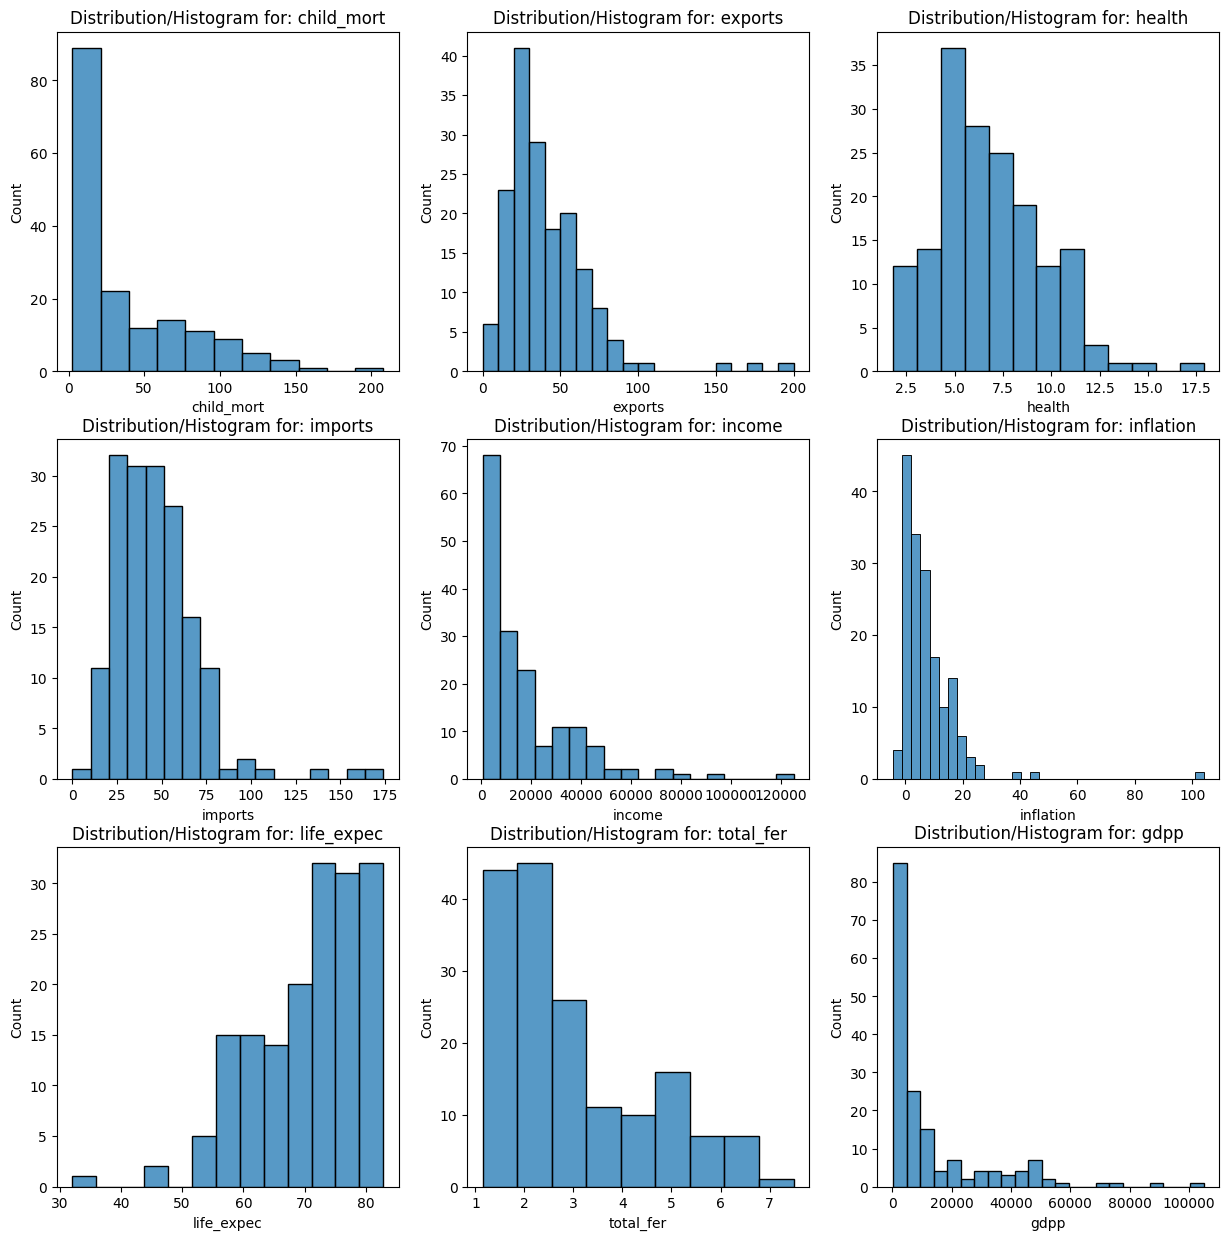

In [9]:
# Create histograms for all numeric columns/features 

fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numeric_features)):
    plt.subplot(3,3,i+1)
    sns.histplot(df_help_data[numeric_features[i]])
    title = 'Distribution/Histogram for: ' + numeric_features[i]
    plt.title(title)
plt.show()

In the above output, we can see the distributions of all features. 



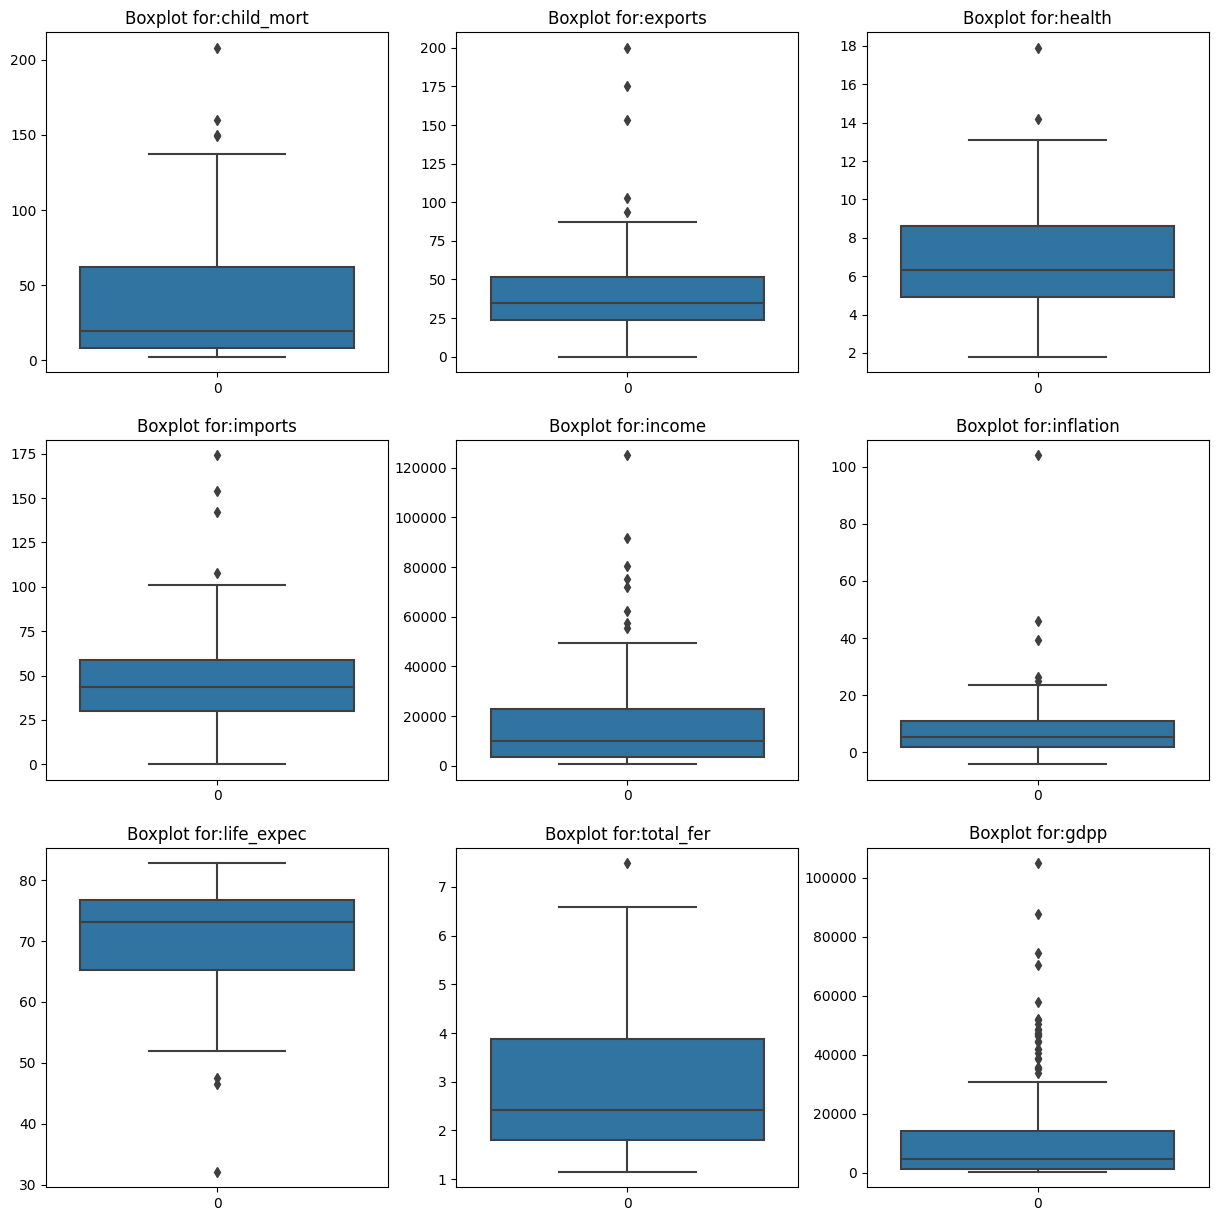

In [10]:
fig  = plt.subplots(nrows = 3,ncols = 3,figsize = (15,15))
for i in range(len(numeric_features)):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(df_help_data[numeric_features[i]])
    plt.title("Boxplot for:" + numeric_features[i])
plt.show()

In the above output is another way to visualize the distributions of the variables/features, boxplots. 

Next, we want to explore the raw data a bit more to see which countries have characteristics of countries in need based on the features available to us in this dataset. To do this, we will look at the top 5 and bottom 5 countries in each category. 

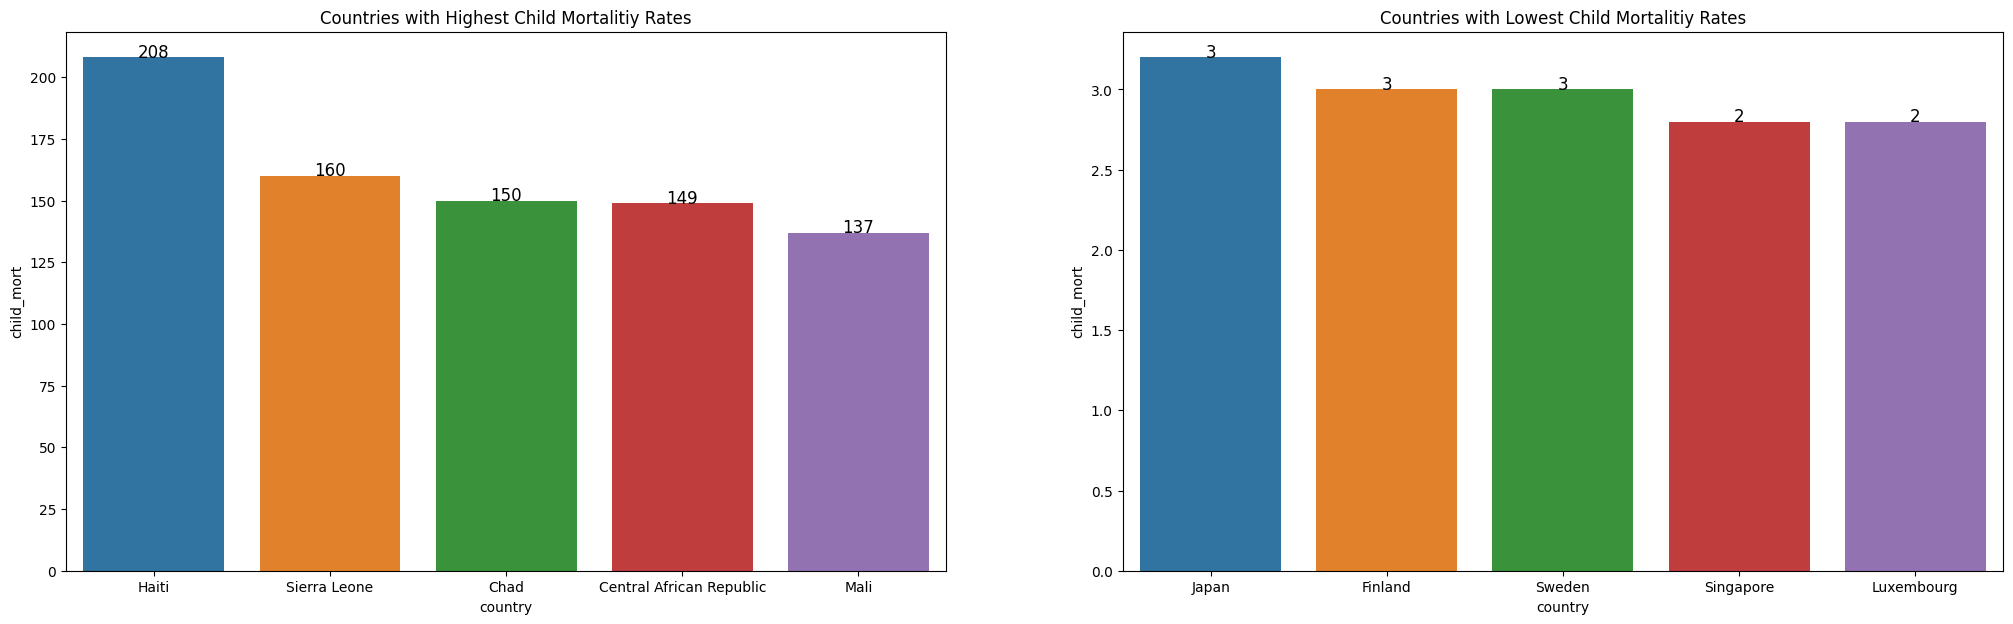

In [11]:
# 5 Highest and 5 Lowest Child Mortality Rates  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'child_mort', data = df_help_data.sort_values(ascending = False,by = 'child_mort').iloc[:5]);
plt.title('Countries with Highest Child Mortalitiy Rates')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'child_mort', data = df_help_data.sort_values(ascending = False,by = 'child_mort').iloc[161:166]);
plt.title('Countries with Lowest Child Mortalitiy Rates')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

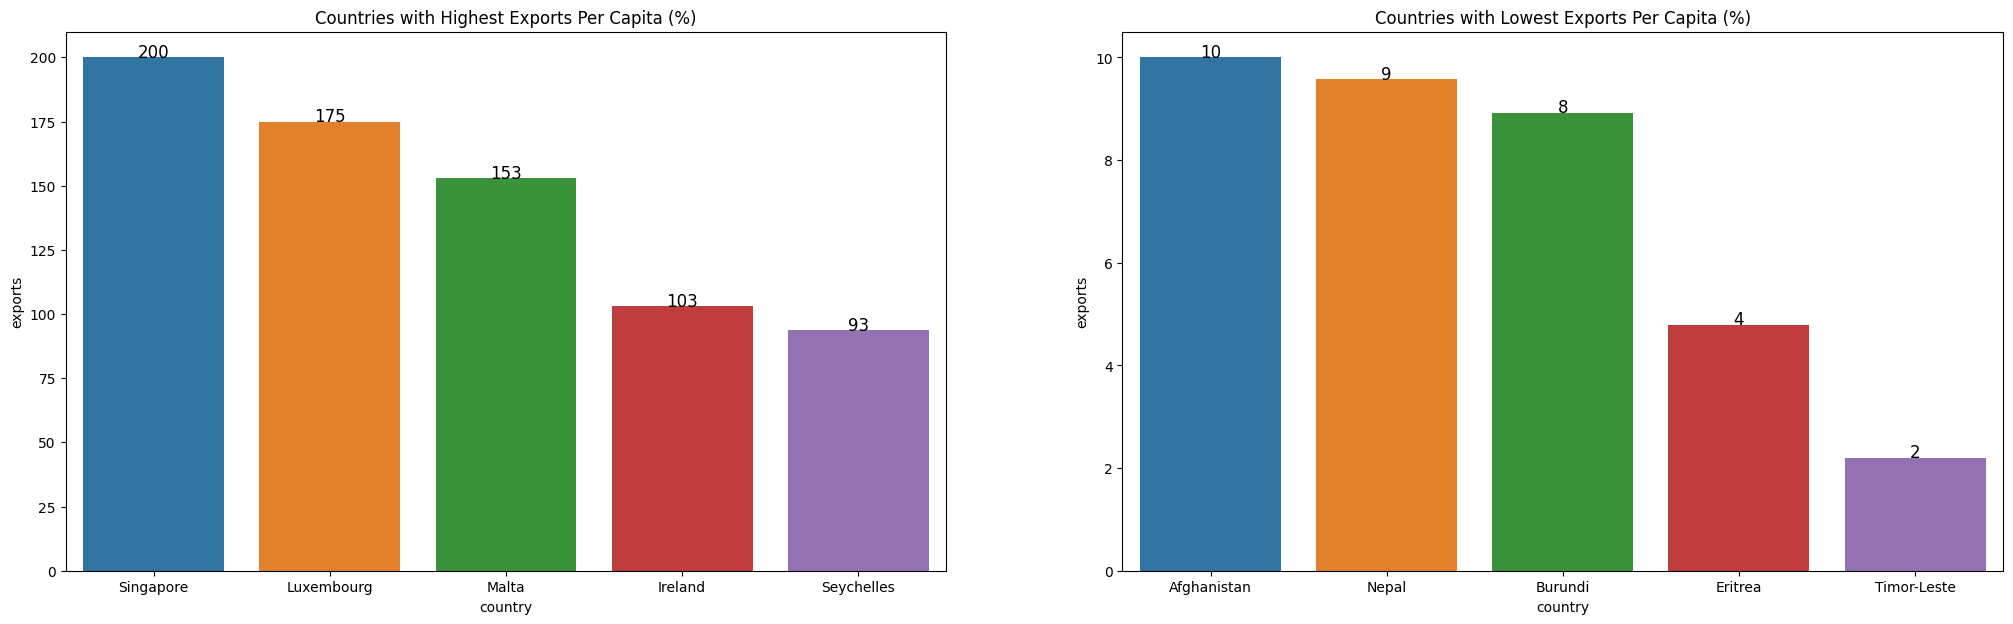

In [12]:
# 5 Highest and 5 Lowest Exports per Capita 

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'exports', data = df_help_data.sort_values(ascending = False,by = 'exports').iloc[:5]);
plt.title('Countries with Highest Exports Per Capita (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
    
plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'exports', data = df_help_data.sort_values(ascending = False,by = 'exports').iloc[161:166]);
plt.title('Countries with Lowest Exports Per Capita (%)')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

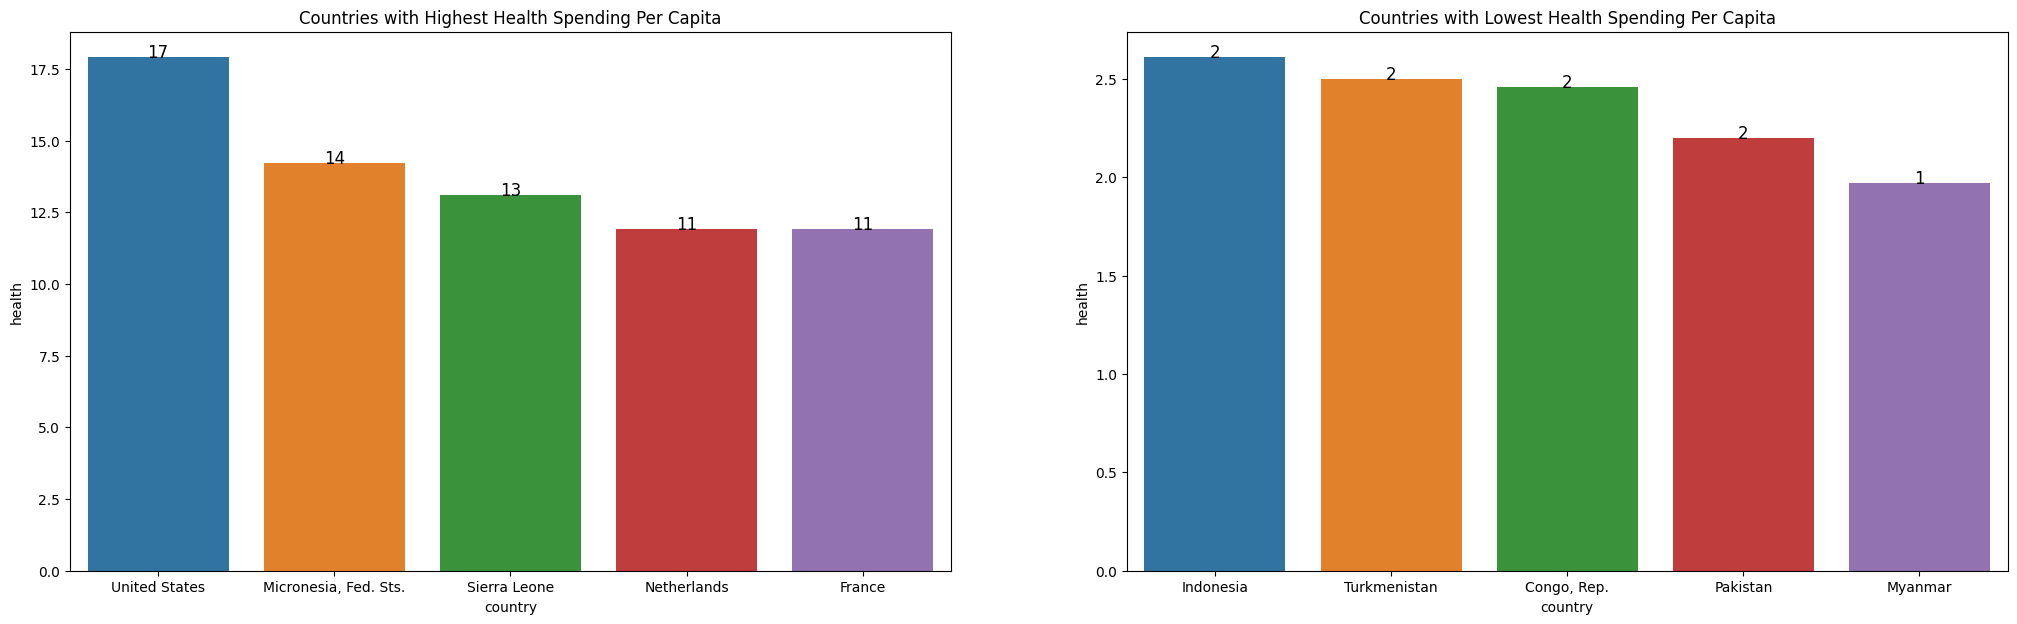

In [13]:
# 5 Highest and 5 Lowest Health Spending Per Capita  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'health', data = df_help_data.sort_values(ascending = False,by = 'health').iloc[:5]);
plt.title('Countries with Highest Health Spending Per Capita')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'health', data = df_help_data.sort_values(ascending = False,by = 'health').iloc[161:166]);
plt.title('Countries with Lowest Health Spending Per Capita')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

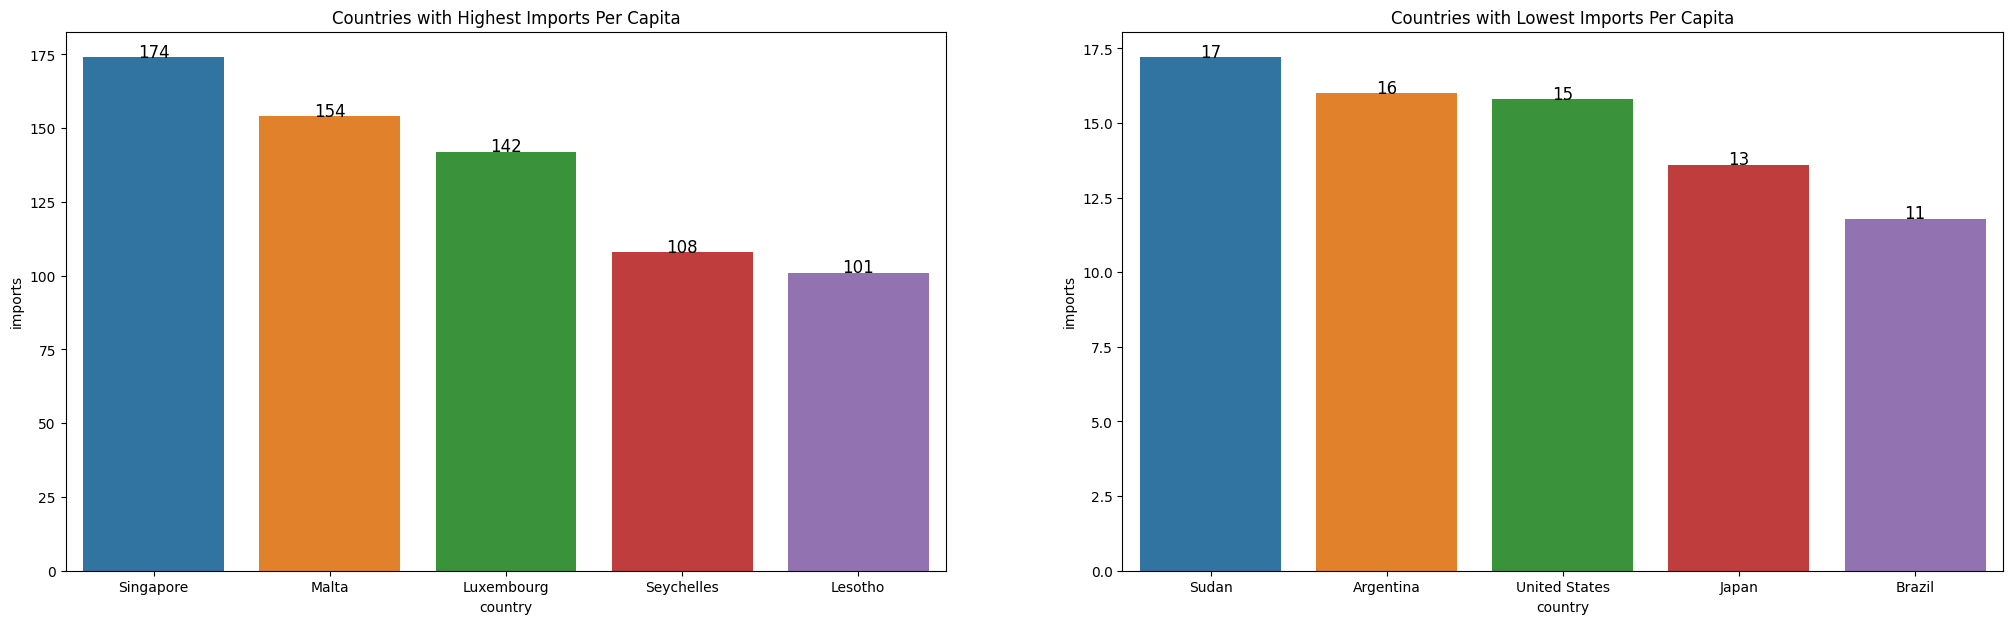

In [14]:
# 5 Highest and 5 Lowest Imports Per Capita  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'imports', data = df_help_data.sort_values(ascending = False,by = 'imports').iloc[:5]);
plt.title('Countries with Highest Imports Per Capita')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'imports', data = df_help_data.sort_values(ascending = False,by = 'imports').iloc[161:166]);
plt.title('Countries with Lowest Imports Per Capita')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

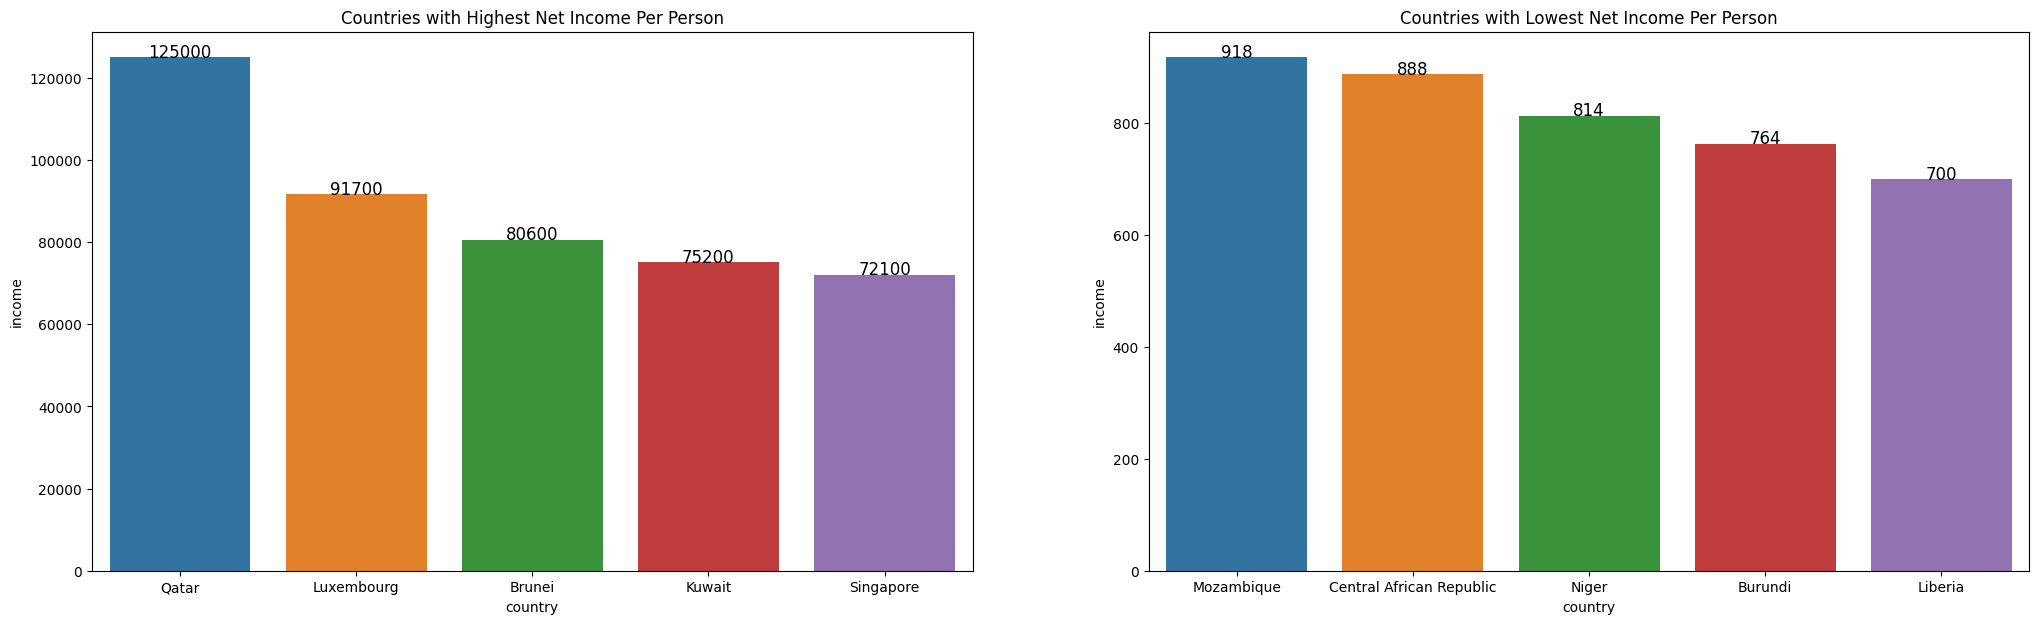

In [15]:
# 5 Highest and 5 Lowest Net Income Per Person 

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'income', data = df_help_data.sort_values(ascending = False,by = 'income').iloc[:5]);
plt.title('Countries with Highest Net Income Per Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'income', data = df_help_data.sort_values(ascending = False,by = 'income').iloc[161:166]);
plt.title('Countries with Lowest Net Income Per Person')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

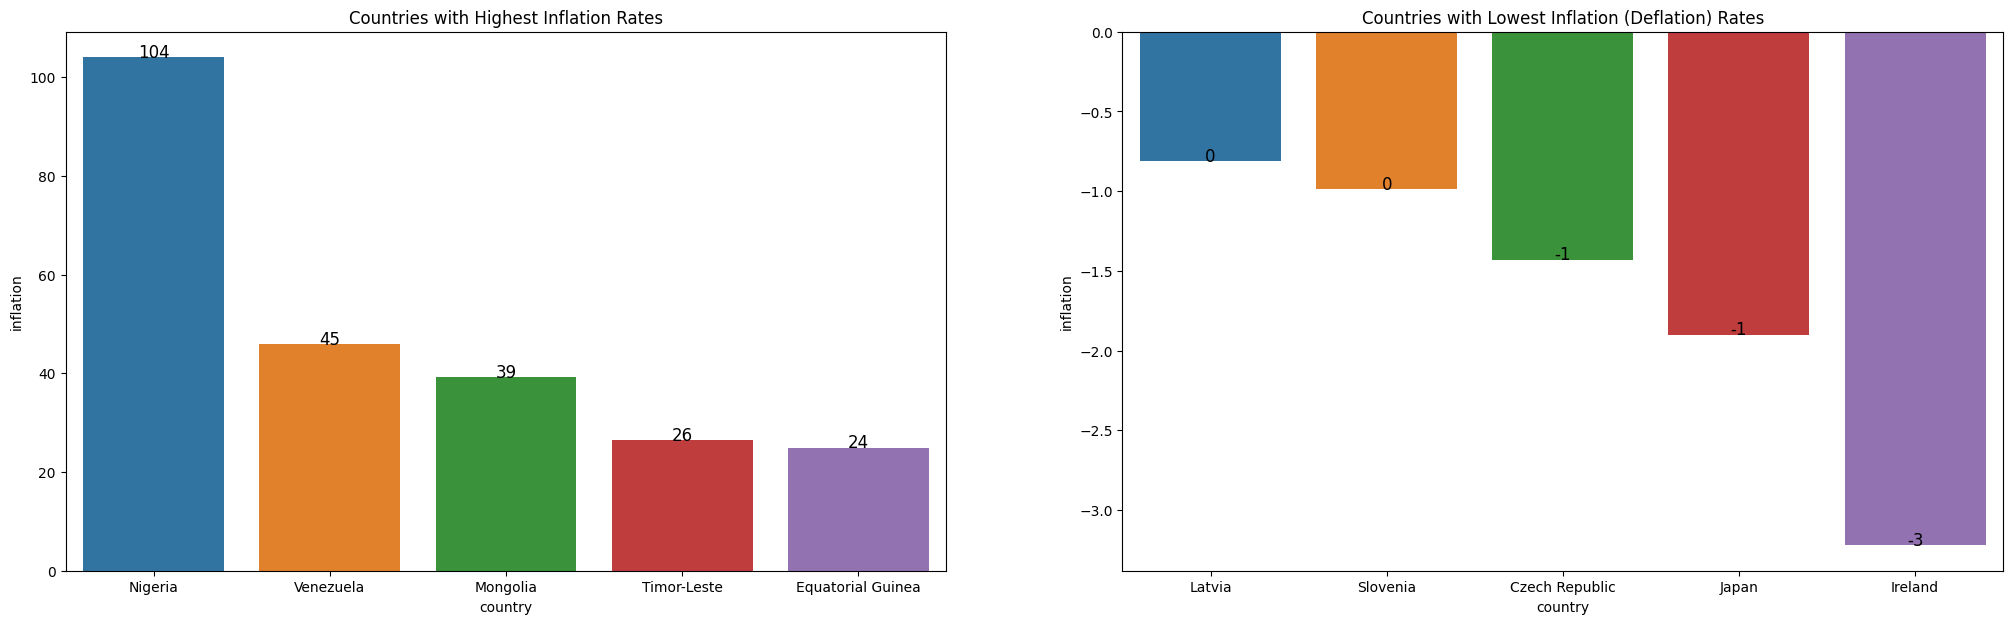

In [16]:
# 5 Highest and 5 Lowest Inflation/Deflation Rates  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'inflation', data = df_help_data.sort_values(ascending = False,by = 'inflation').iloc[:5]);
plt.title('Countries with Highest Inflation Rates')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'inflation', data = df_help_data.sort_values(ascending = False,by = 'inflation').iloc[161:166]);
plt.title('Countries with Lowest Inflation (Deflation) Rates')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

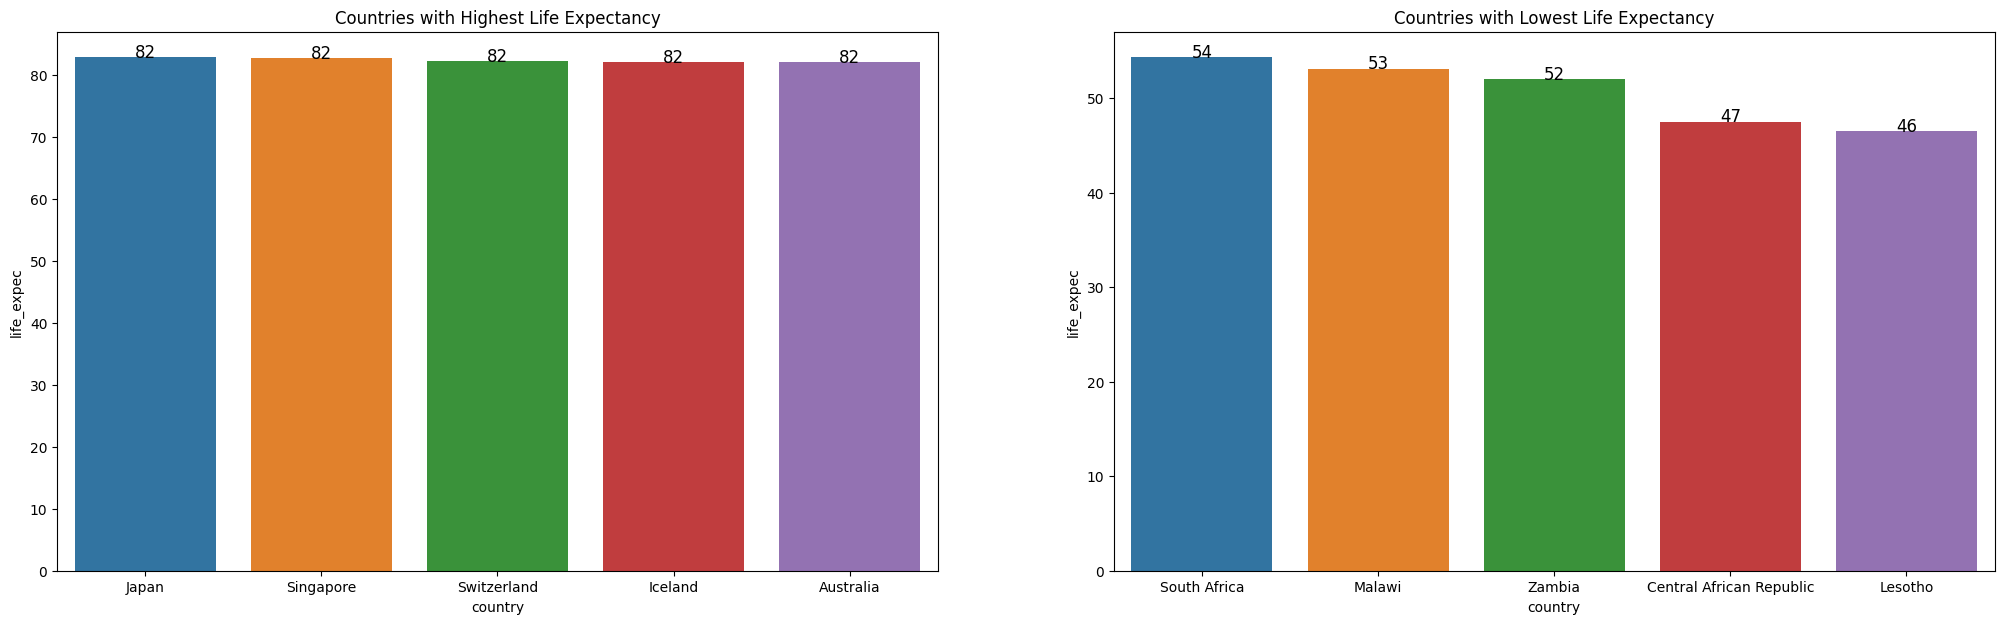

In [17]:
# 5 Highest and 5 Lowest Life Expectancy  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'life_expec', data = df_help_data.sort_values(ascending = False,by = 'life_expec').iloc[:5]);
plt.title('Countries with Highest Life Expectancy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'life_expec', data = df_help_data.sort_values(ascending = False,by = 'life_expec').iloc[161:166]);
plt.title('Countries with Lowest Life Expectancy')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

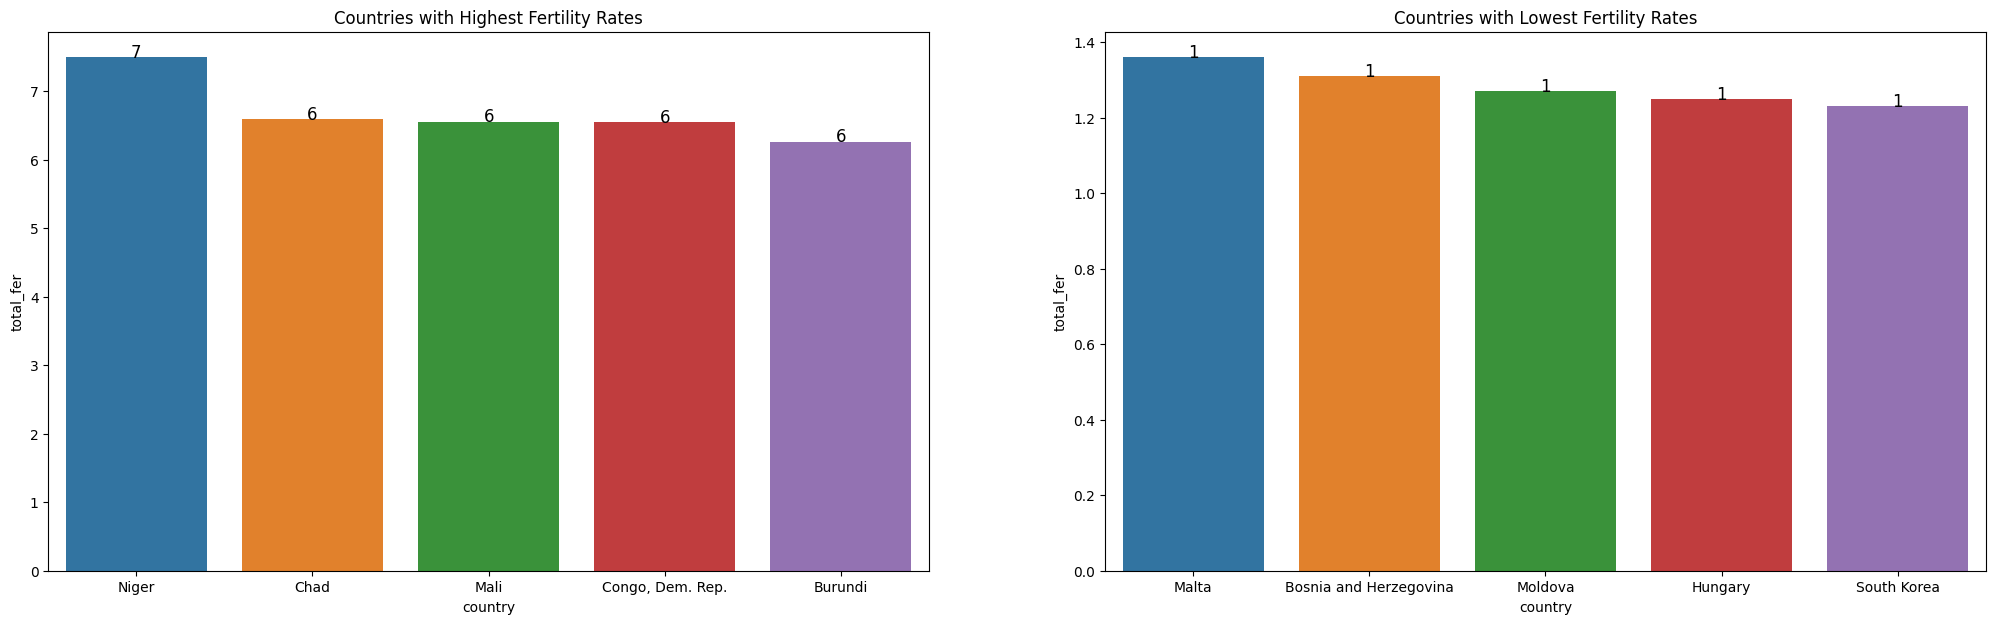

In [18]:
# 5 Highest and 5 Lowest Fertility Rates  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'total_fer', data = df_help_data.sort_values(ascending = False,by = 'total_fer').iloc[:5]);
plt.title('Countries with Highest Fertility Rates')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'total_fer', data = df_help_data.sort_values(ascending = False,by = 'total_fer').iloc[161:166]);
plt.title('Countries with Lowest Fertility Rates')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

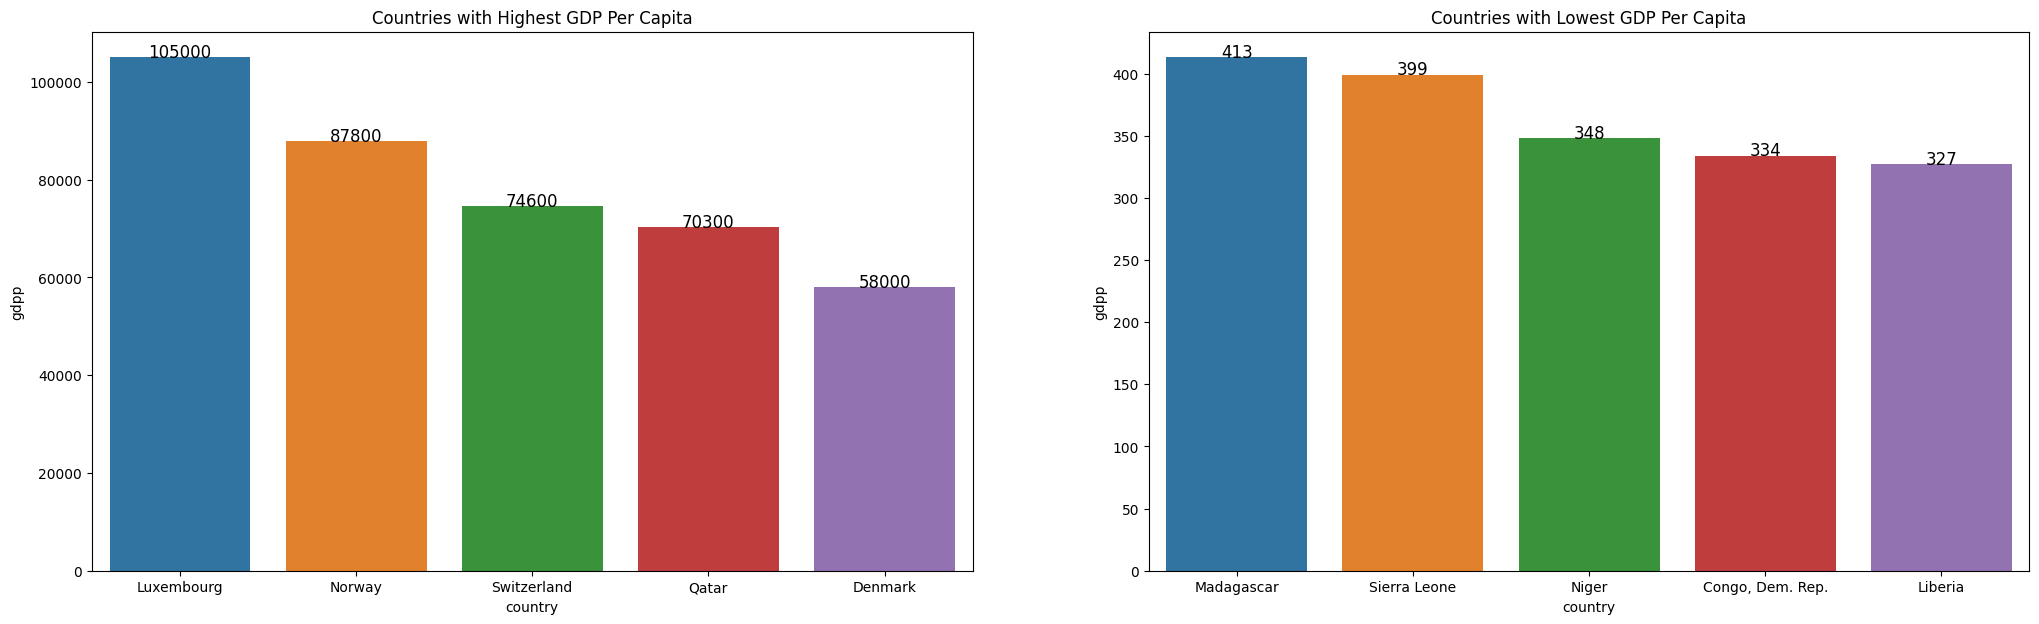

In [19]:
# 5 Highest and 5 Lowest GDP Per Capita  

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (25,7))

plt.subplot(1,2,1)
ax = sns.barplot(x = 'country',y = 'gdpp', data = df_help_data.sort_values(ascending = False,by = 'gdpp').iloc[:5]);
plt.title('Countries with Highest GDP Per Capita')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)

plt.subplot(1,2,2)
ax = sns.barplot(x = 'country',y = 'gdpp', data = df_help_data.sort_values(ascending = False,by = 'gdpp').iloc[161:166]);
plt.title('Countries with Lowest GDP Per Capita')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), int(rect.get_height()), 
            horizontalalignment='center', fontsize = 12)
plt.show()

And now, lets create a correlation matrix! 

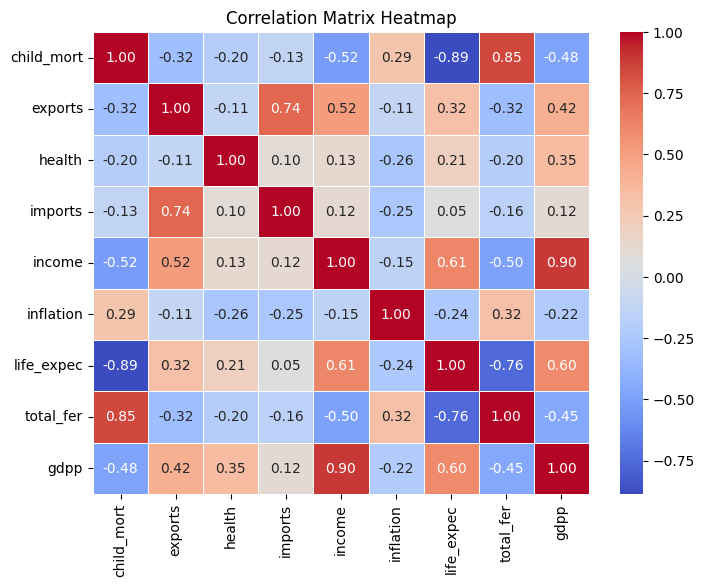

In [20]:
df_help_numeric = df_help_data.drop(columns = ["country"])

correlation_matrix = df_help_numeric.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')  # Set the title
plt.show()

In the above correlation matrix, we can see that there are many variables that are correlated relatively strongly with each other. This likely means that these highly correlated features are likely providing duplicate information. An example of this is income and GDP. These both correspond to the economic status of the country. 

One approach could be to use subject matter expertise and collapse some of the features, however I am not a geopolitical or international economics expert, so instead I will use PCA for dimensionality reduction. 

In [21]:
# Normalize and Standardize data prior to PCA 

mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df_pca = df_help_data.copy(deep = True)

cols = list(df_help_data.columns)
cols.remove('health'); cols.remove('country')

df_pca['health'] = ss.fit_transform(df_pca[['health']]) 

for i in cols:
    df_pca[i] = mms.fit_transform(df_pca[[i]]) 
    
df_pca.drop(columns = 'country',inplace = True) 
df_pca.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.279088,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,-0.097016,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,-0.966073,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,-1.448071,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,-0.286894,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


In [22]:
pca = PCA()
df_pca_2 = pd.DataFrame(pca.fit_transform(df_pca))
pca.explained_variance_

array([1.01740511, 0.13090418, 0.03450018, 0.02679822, 0.00979752,
       0.00803398, 0.00307055, 0.00239976, 0.00179388])

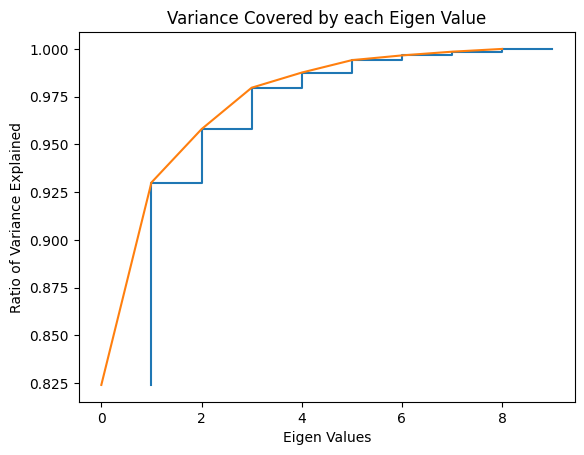

In [23]:
plt.step(list(range(1,10)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()

Based on the above output, an Eigen value of 2 is appropriate here as >95% of the variance is explained. 

In [24]:
df_pca_2 = df_pca_2.drop(columns = [3,4,5,6,7,8])
df_pca_2.head()

,0,1,2
0,0.220482,0.640048,0.086112
1,-0.080903,-0.172000,-0.208695
2,-0.961283,-0.125199,-0.126719
3,-1.505914,0.472144,0.284978
4,-0.264724,-0.237308,-0.059150


In [25]:
df_pca_2.head()

,0,1,2
0,0.220482,0.640048,0.086112
1,-0.080903,-0.172000,-0.208695
2,-0.961283,-0.125199,-0.126719
3,-1.505914,0.472144,0.284978
4,-0.264724,-0.237308,-0.059150


## **EDA Conclusion/Discussion**

In summary, in this EDA we saw the distributions of all numeric features in the dataset and observed that most of them were skewed. We also visualized box plots for each feature and saw that there were outliers for many of the features. Additionally, we looked at the raw data for the 5 highest and lowest ranked countries for each feature. This provided some intuition around what features are most important. Next we looked at the correlation matrix and saw that several features were highly correlated with each other and likely provided similar information. Finally, to address this, we performed normalization, standardization, and PCA. We are now ready to move on to modeling. 

## **Step 4: Perform Analysis Using Unsupervised Learning Models of your Choice, PResent Discussion, and Conclusions**

For this project, I plan to create a compare 2 models: a K-Means Clustering Model and a Hierarchical Clustering Model. 

### **K-Means Clustering Model**


In [26]:
modeling_data = df_pca_2.values

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

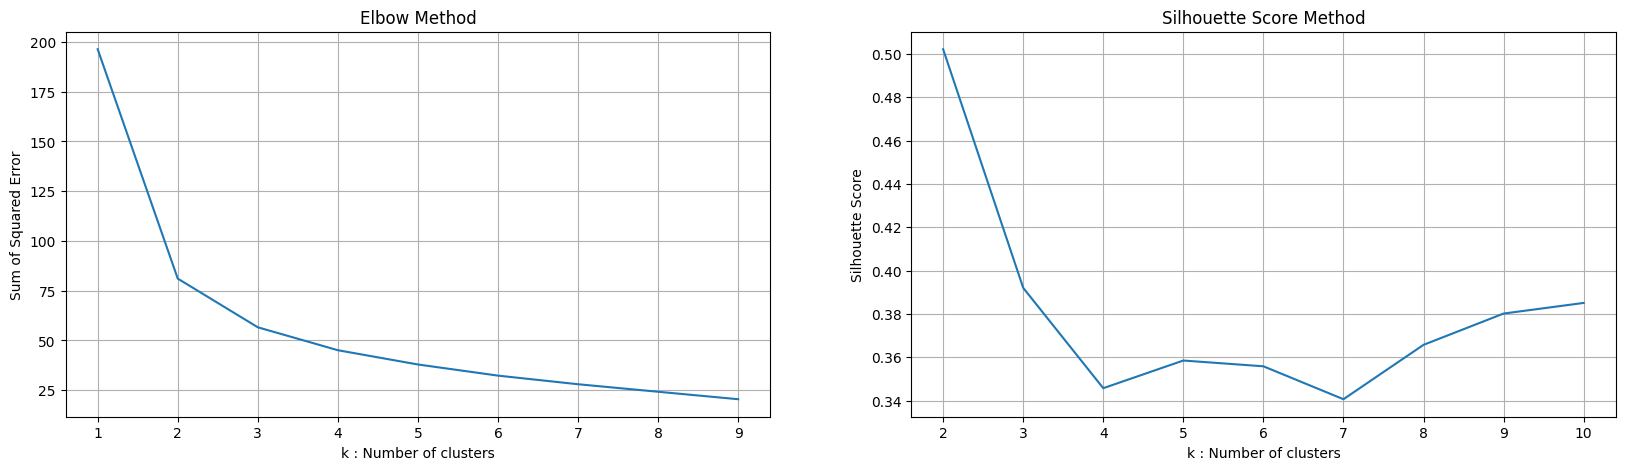

In [27]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(modeling_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of clusters")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(modeling_data)
    labels = kmeans.labels_
    sil.append(silhouette_score(modeling_data, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of clusters")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()


Here the elbow method seems to suggest a k of 2, while the silhouette method seems to suggest a k of 4. I'll choose the value in between, k = 3. 

In [28]:
model = KMeans(n_clusters = 3,max_iter = 1000)
model.fit(modeling_data)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
df_help_data['Class'] = labels
df_pca_2['Class'] = labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


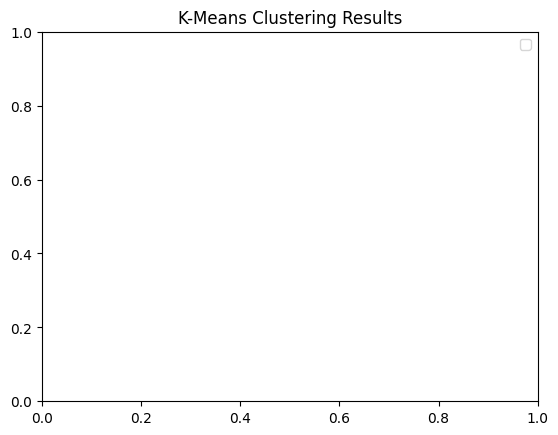

In [29]:
fig = plt.figure()
ax = Axes3D(fig)
x = df_pca_2[0]
y = df_pca_2[1]
z = df_pca_2[2]
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],marker="X", color = 'b', label = 'Centroids')
plt.title('K-Means Clustering Results')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
ax.scatter(x,y,z,c = y, cmap='viridis', label='Data Points')
plt.legend()
plt.show();

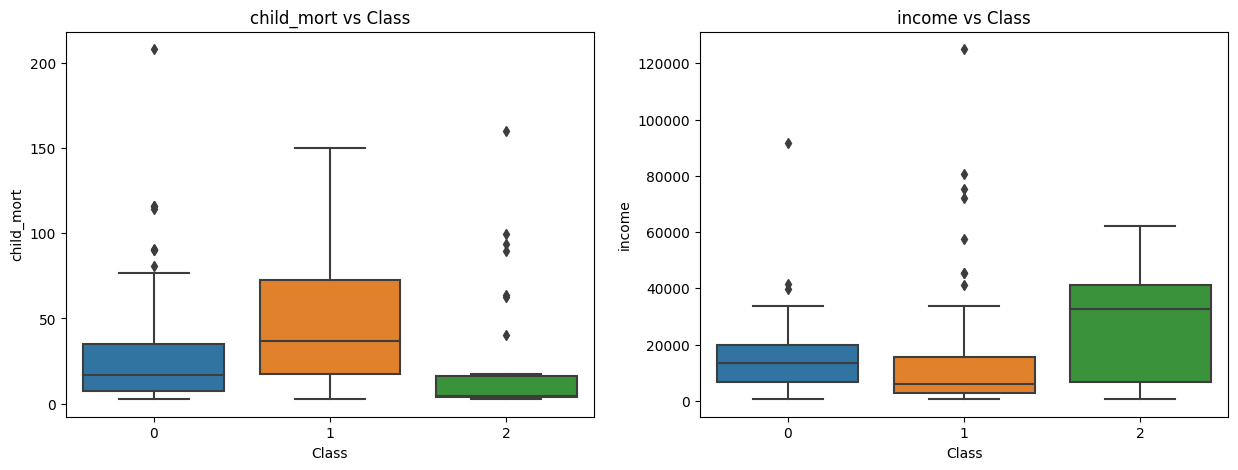

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = df_help_data);
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = df_help_data);
plt.title('income vs Class')

plt.show()


Given the above output, it appears that the class that represents the group of countries where aid might be most impactful is class 1. 

In [31]:
df_pca_2.insert(0,column = 'Country', value = df_help_data['country'])

In [32]:
df_pca_2['Class'].loc[df_pca_2['Class'] == 0] = 'Aid Moderately Impactful'
df_pca_2['Class'].loc[df_pca_2['Class'] == 1] = 'Aid Most Impactful'
df_pca_2['Class'].loc[df_pca_2['Class'] == 2] = 'Aid Least Impactful/Not Needed'

fig = px.choropleth(df_pca_2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Where Will Aid Be Most Impactful?',
                    color = df_pca_2['Class'],  
                    color_discrete_map = {'Aid Most Impactful':'Orange',
                                          'Aid Moderately Impactful':'Yellow',
                                          'Aid Least Impactful/Not Needed': 'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')


/tmp/ipykernel_1666/1040651409.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pca_2['Class'].loc[df_pca_2['Class'] == 0] = 'Aid Moderately Impactful'
/tmp/ipykernel_1666/1040651409.py:1: SettingWithCopyWarning: 
A value is trying to 

### **Hierarchical Clustering Model**

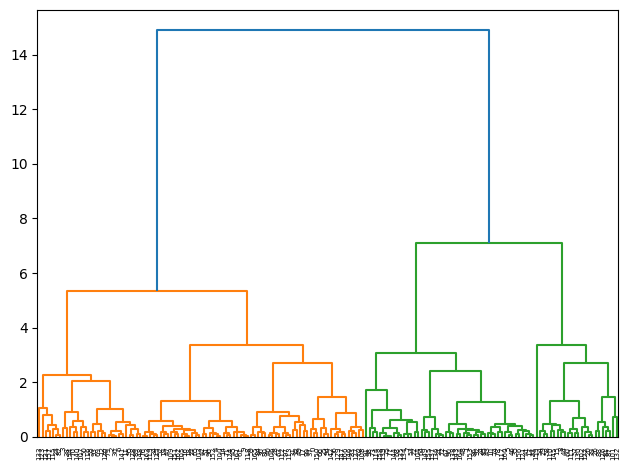

In [33]:
linkage_data = linkage(modeling_data, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [34]:
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = hierarchical_cluster.fit(modeling_data)

pred_agc = pd.Series(hierarchical_cluster.labels_)
df_help_data['Class'] = pred_agc; df_pca_2['Class'] = pred_agc

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



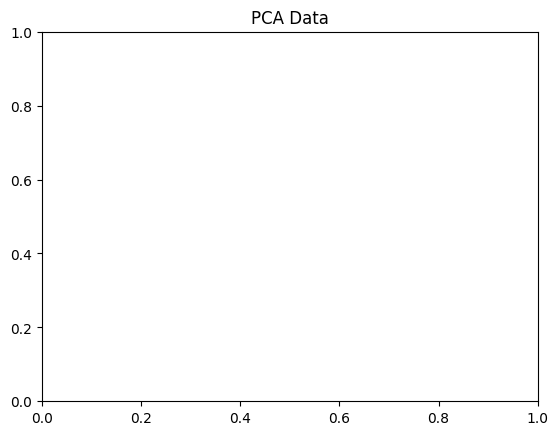

In [35]:
fig = plt.figure()
ax = Axes3D(fig)
x = np.array(df_pca_2[0])
y = np.array(df_pca_2[1])
z = np.array(df_pca_2[2])
ax.scatter(x,y,z,c = df_pca_2['Class'])
plt.title('PCA Data')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
plt.show();

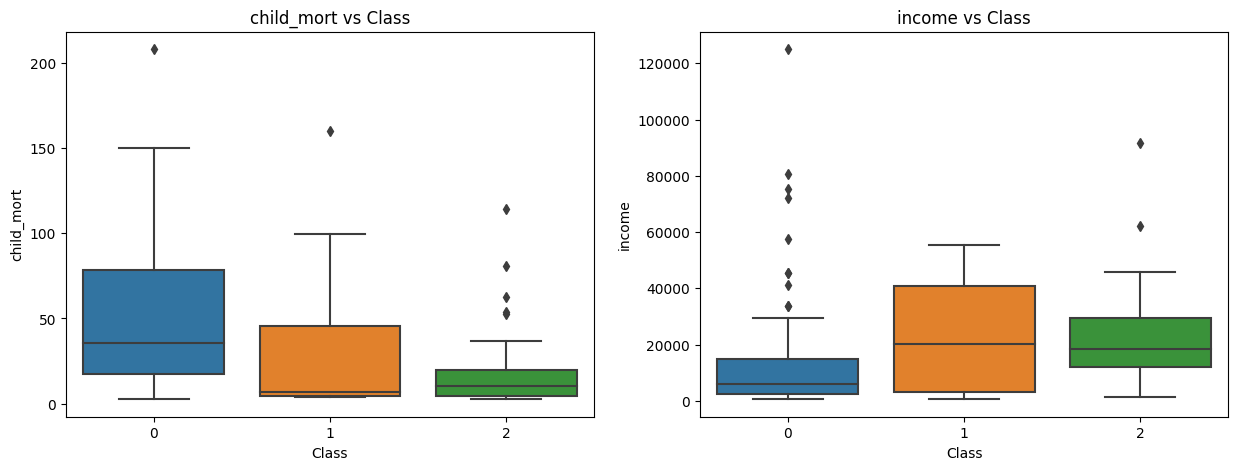

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'child_mort', data  = df_help_data);
plt.title('child_mort vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'income', data  = df_help_data);
plt.title('income vs Class')

plt.show()

From the above output, we can see that class 0 is where aid will be most impactful, aid might be moderately helpful in class 1, and no aid is needed in class 2. 

In [37]:
df_pca_2['Class'].loc[df_pca_2['Class'] == 0] = 'Aid Most Impactful'
df_pca_2['Class'].loc[df_pca_2['Class'] == 1] = 'Aid Moderately Impactful'
df_pca_2['Class'].loc[df_pca_2['Class'] == 2] = 'Aid Least Impactful/Not Needed'

fig = px.choropleth(df_pca_2[['Country','Class']],
                    locationmode = 'country names',
                    locations = 'Country',
                    title = 'Where Will Aid Be Most Impactful?',
                    color = df_pca_2['Class'],  
                    color_discrete_map = {'Aid Most Impactful':'Orange',
                                          'Aid Moderately Impactful':'Yellow',
                                          'Aid Least Impactful/Not Needed': 'Green'})
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')


/tmp/ipykernel_1666/3714022591.py:1: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_1666/3714022591.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

### **Results and Analysis** 

In this analysis, we attempted 2 models, a K-Means and a Hierarchical clustering model. Please see above for the relevant visualizations. The most informative visualizations are the maps. It is difficult to discern model performance as this is ultimately a subjective decision. However, anecdotally, both models seem to do a good job of capturing the countries where aid will be most impactful. The higher two clusters are not ideal in either model, but fortunately they weren't the "target" for this analysis. 

### **Discussion and Conclusion** 

Overall, the task of determining where to deploy aid is a difficult task. Some key takeways from this project include the importance of determining a more fine-grained goal for clustering tasks if the goal is to provide a recommendation for action. Another key takeaway is that it may be worth spending more time really homing in on what K is best for the problem at hand. 

It seems like neither model was exceptional (did not work) because of the choice of K. 

In the future, this could be improved by spending more time with the features and maybe taking a different approach than PCA. Perhaps some subject matter expertise in the dimensionality reduction step would have resulted in better performance. 

[Link to GitHub Repository](https://github.com/bryanpmayfield/DTSA_5510_Final_Project)